In [28]:
from pyomo.environ import ConcreteModel, Var, Objective, Constraint, SolverFactory, Binary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [29]:
def carregar_instancia(csv_file):

    df = pd.read_csv(csv_file)

    cap_row = df[df['Item'].str.lower() == 'capacidade']
    if not cap_row.empty:
        capacity = float(cap_row['Valor'].values[0])
        df = df[df['Item'].str.lower() != 'capacidade']
    else:
        capacity = 15.0

    items = df['Item'].tolist()
    values = df['Valor'].tolist()
    weights = df['Peso'].tolist()

    return items, values, weights, capacity


In [30]:
def resolver_mochila(items, values, weights, capacity):
    model = ConcreteModel()
    model.x = Var(items, domain=Binary)

    model.obj = Objective(expr=sum(values[i] * model.x[items[i]] for i in range(len(items))),
                          sense='maximize')

    model.capacity_constraint = Constraint(expr=sum(weights[i] * model.x[items[i]] for i in range(len(items))) <= capacity)

    solver = SolverFactory('glpk')
    start_time = time.time()
    resultado = solver.solve(model)
    elapsed_time = time.time() - start_time

    resultados_itens = pd.DataFrame({
        'Item': items,
        'Valor': values,
        'Peso': weights,
        'Selecionado': [model.x[item].value for item in items]
    })

    valor_otimo = model.obj.expr()

    return resultados_itens, valor_otimo, elapsed_time

In [31]:
instancias = ['data/C1.csv', 'data/C2.csv', 'data/C3.csv', 'data/C4.csv']

comparativo_itens = []
comparativo_valor = []

for csv_file in instancias:
    items, values, weights, capacity = carregar_instancia(csv_file)

    resultados_itens, valor_otimo, tempo = resolver_mochila(items, values, weights, capacity)

    print(f"\nResultados detalhados para {csv_file}:")
    print(resultados_itens)

    comparativo_itens.append({
        'Instancia': csv_file,
        'Num_itens': len(items),
        'Capacidade': capacity,
        'Valor_total_selecionado': resultados_itens.loc[resultados_itens['Selecionado']==1, 'Valor'].sum(),
        'Tempo_segundos': tempo
    })

    comparativo_valor.append({
        'Instancia': csv_file,
        'Valor_otimo': valor_otimo,
        'Tempo_segundos': tempo
    })



Resultados detalhados para data/C1.csv:
                  Item  Valor  Peso  Selecionado
0       Notebook Gamer   7500   2.8          1.0
1          Câmera DSLR   4200   1.9          1.0
2               Tablet   2300   0.7          1.0
3       Fone Bluetooth    800   0.3          1.0
4                Livro    350   1.2          1.0
5  Carregador Portátil    600   0.4          1.0

Resultados detalhados para data/C2.csv:
                  Item   Valor  Peso  Selecionado
0       Notebook Gamer  7500.0   2.8          1.0
1          Câmera DSLR  4200.0   1.9          1.0
2               Tablet  2300.0   0.7          1.0
3       Fone Bluetooth   800.0   0.3          1.0
4                Livro   350.0   1.2          0.0
5  Carregador Portátil   600.0   0.4          1.0
6           Smartwatch  1200.0   0.2          1.0
7           Headphones  1500.0   0.5          1.0

Resultados detalhados para data/C3.csv:
                  Item   Valor  Peso  Selecionado
0               Tablet  2300.0   0

In [32]:
df_comparativo_itens = pd.DataFrame(comparativo_itens)
df_comparativo_valor = pd.DataFrame(comparativo_valor)

# Mostrar tabelas
print("\n=== Comparativo por itens selecionados ===")
display(df_comparativo_itens)

print("\n=== Comparativo pelo valor ótimo da função objetivo ===")
display(df_comparativo_valor)


=== Comparativo por itens selecionados ===


,Instancia,Num_itens,Capacidade,Valor_total_selecionado,Tempo_segundos
0,data/C1.csv,6,15.0,15750.0,0.057238
1,data/C2.csv,8,7.0,18100.0,0.048101
2,data/C3.csv,4,2.0,3700.0,0.038306
3,data/C4.csv,6,6.0,14800.0,0.024325



=== Comparativo pelo valor ótimo da função objetivo ===


,Instancia,Valor_otimo,Tempo_segundos
0,data/C1.csv,15750.0,0.057238
1,data/C2.csv,18100.0,0.048101
2,data/C3.csv,3700.0,0.038306
3,data/C4.csv,14800.0,0.024325


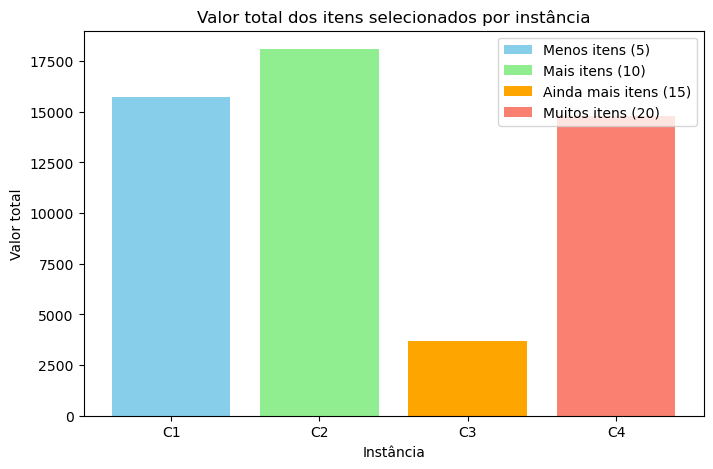

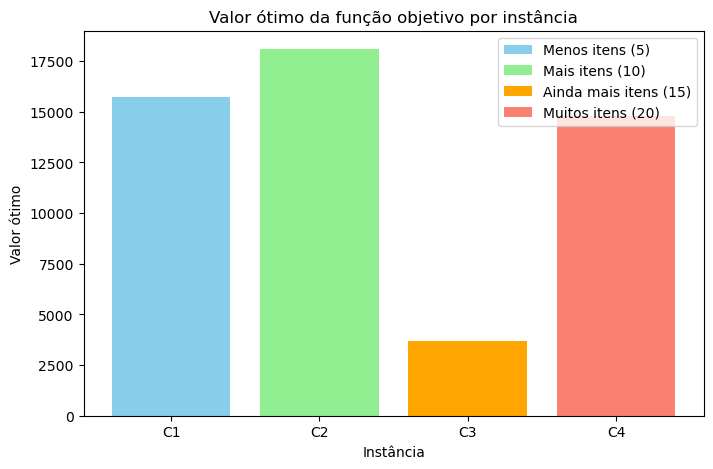

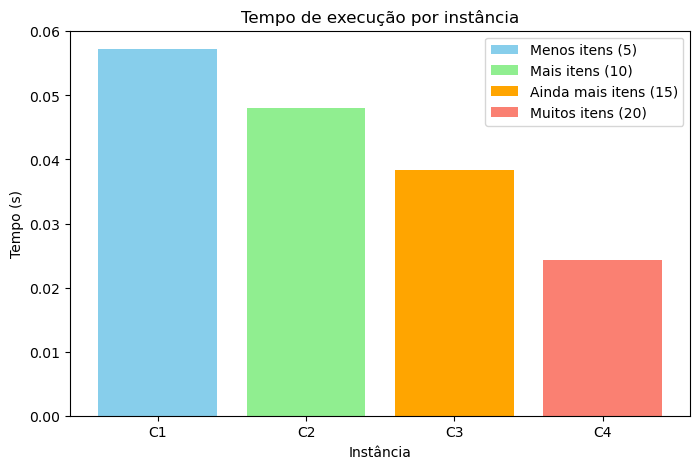

In [35]:
# Rótulos para os gráficos
instancias_rotulo = ['C1', 'C2', 'C3', 'C4']
legenda = [
    'Menos itens (5)',
    'Mais itens (10)',
    'Ainda mais itens (15)',
    'Muitos itens (20)'
]

cores = ['skyblue', 'lightgreen', 'orange', 'salmon']

# --- Gráfico 1: Valor total dos itens selecionados ---
plt.figure(figsize=(8,5))
barras = plt.bar(instancias_rotulo, df_comparativo_itens['Valor_total_selecionado'], color=cores)
plt.title('Valor total dos itens selecionados por instância')
plt.xlabel('Instância')
plt.ylabel('Valor total')
plt.legend(barras, legenda)
plt.show()

# --- Gráfico 2: Valor ótimo da função objetivo ---
plt.figure(figsize=(8,5))
barras = plt.bar(instancias_rotulo, df_comparativo_valor['Valor_otimo'], color=cores)
plt.title('Valor ótimo da função objetivo por instância')
plt.xlabel('Instância')
plt.ylabel('Valor ótimo')
plt.legend(barras, legenda)
plt.show()

# --- Gráfico opcional: Tempo de execução ---
plt.figure(figsize=(8,5))
barras = plt.bar(instancias_rotulo, df_comparativo_itens['Tempo_segundos'], color=cores)
plt.title('Tempo de execução por instância')
plt.xlabel('Instância')
plt.ylabel('Tempo (s)')
plt.legend(barras, legenda)
plt.show()
